# Lab 7: Bayesian Hierarchical Modeling

### Lab Date: Wednesday, Mar 12

### Lab Due: Wednesday, Mar 19

## Instructions

Work with your lab group to complete the following notebook. Your work will be reviewed by your peers in lab next week (Wednesday, March 19)

In this lab, you will:
1. Understand the Bayesian hierarchical model in the context of image reconstruction.
2. Apply the Fourier transform as a transformation matrix in an inverse problem.
3. Implement Maximum A Posteriori (MAP) estimation using:
	- Coordinate Ascent Optimization
	- Gradient-Based Optimization (L-BFGS-B)
4. Compute and interpret Laplace Approximation to estimate posterior uncertainty.
5. Compare the effectiveness of different optimization methods in Bayesian inference.

This lab applies Bayesian sparse regression to the MNIST dataset, where images of handwritten digits are processed and reconstructed using probabilistic models.

If you are new to working in python, or in a Jupyter notebook, please ask your lab members for help. If you notice a lab member struggling, and have experience, please offer your help.

Please see this [Ed post](https://edstem.org/us/courses/74615/discussion/6257662) for corrections, questions, and discussion. If you would rather work with your own copy of the files, I have uploaded a zip folder there with the lab materials. 

Corrections to the lab will be pushed directly to this notebook. We will only push corrections to the text, which is set to read only to prevent merge conflicts. In the event of a merge conflict, save your notebook under a different name, and click the link that launches the lab from the schedule on the [stat238 homepage](https://stat238.berkeley.edu/spring-2025/) again. Then, check for discrepancies. If you can't find them, or resolve the conflict, contact us.

### Introduction

Image reconstruction is a common problem in fields such as medical imaging (MRI, CT scans) and astronomical imaging. In this lab, we explore a Bayesian hierarchical model to reconstruct an image that has been transformed by the Fourier Transform and potentially affected by noise.

We assume that the true image $X$ is transformed by an operator $A$, and we observe $Y$:
$$Y = A X + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2 I)$$
where $A$ represents the Fourier transform matrix.

To recover $X$, we use a Bayesian hierarchical model, assuming a Gaussian prior:
$$X_i \sim \mathcal{N}(0, \tau^2)$$
and placing an Inverse-Gamma hyperprior on $\tau^2$:
$$\tau^2 \sim \text{Inv-Gamma}(\alpha, \beta)$$

Our goal is to estimate $X$ using MAP estimation and compare different optimization methods.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
from scipy.linalg import inv
from scipy.stats import invgamma
from numpy.fft import fft2, ifft2
from scipy.optimize import minimize

In [10]:
# Load an MNIST digit as an example
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((28, 28))])
mnist_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# Select an image from the dataset
img, label = mnist_dataset[0]  # Get the first image
img_array = img.squeeze().numpy()  # Convert from PyTorch tensor to NumPy
X_true = img_array.flatten()  # Flatten the image for processing

### Step 1: Constructing the Fourier Transformation Matrix

1. Define a function that constructs the Fourier transform matrix for an image of size $N \times N$.
2. Ensure that the transformation matrix only considers the real part for numerical stability.
3. Normalize the matrix such that its maximum value is 1.
$$A = \text{Re}(\mathcal{F}(I))$$
where $\mathcal{F}$ represents the 2D Fourier transform applied to the identity matrix.

In [11]:
# Define the Fourier Transform based observation model
def fourier_transform_matrix(size):
    """Create a Fourier transformation matrix."""
    A = np.fft.fft2(np.eye(size)).real  # Use only the real part for numerical stability
    return A / np.max(A)  # Normalize the matrix

### Step 2: Simulating Observations
1. Select an MNIST image and flatten it into a vector $X_{\text{true}}$.
2. Apply the Fourier transformation matrix $A$.
3. Generate observations by applying $A$ to $X_{\text{true}}$.

In [12]:
# Define noise level
noise_std = 0.05  # Standard deviation of Gaussian noise

# Apply the transformation matrix and add noise
A = fourier_transform_matrix(len(X_true))
Y = A @ X_true + np.random.normal(0, noise_std, size=X_true.shape)  # Noisy observations

### Step 3: Implementing Coordinate Ascent for MAP Estimation

To maximize the posterior probability, we use Coordinate Ascent to iteratively update each coordinate of $X$ and estimate $\tau^2$ using MAP estimation from the posterior.

Updating $X_i$ (Coordinate-wise Optimization)

Coordinate ascent is an iterative optimization technique that updates one variable at a time while keeping others fixed. It is commonly used in problems where the full optimization problem is hard to solve directly but can be broken down into simpler subproblems.

In our case, we seek to maximize the posterior distribution of X given Y, which is equivalent to minimizing the negative log-posterior:
$$J(X) = \| A X - Y \|^2 + \frac{1}{2\tau^2} \sum X_i^2 = \sum_i \left( (a_i^T X - Y)^2 + \frac{X_i^2}{2\tau^2} \right)$$

Instead of optimizing all $X_i$ at once, we update each coordinate separately using coordinate ascent.

Since only $X_i$ is being updated, we isolate it in the objective:
$$J(X_i) = (a_i^T X - Y)^2 + \frac{X_i^2}{2\tau^2}$$
Differentiating with respect to $X_i$ and setting to zero:
$$X_i^{(t+1)} = \frac{a_i^T(Y - A X + a_i X_i)}{a_i^T a_i + 1/\tau^2}$$

Thus for each coordinate $i$, we update $X_i$ using the formula:
$$X_i^{(t+1)} = \frac{a_i^T (Y - A X + a_i X_i)}{a_i^T a_i + 1/\tau^2}$$
where $a_i$ is the $i$-th column of $A$

Estimating $\tau^2$ using MAP estimation

We obtain the MAP estimate by maximizing its density:
$$p(\tau^2 | X) \propto (\tau^2)^{-(\alpha + n/2 + 1)} e^{-\frac{\beta + 0.5 \sum X_i^2}{\tau^2}}$$

Taking the derivative and solving for \tau^2, we obtain the MAP estimator:

$$\tau^2_{\text{MAP}} = \frac{\beta + 0.5 \sum X_i^2}{\alpha + n/2 + 1}$$

1. Implement coordinate ascent to iteratively update each variable $X_i$.
2. Update the hyperparameter $\tau^2$ using an Inverse-Gamma posterior.


In [13]:
# Implement Coordinate Ascent
def coordinate_ascent_fourier(A, Y, alpha=2.0, beta=2.0, tol=1e-6, max_iter=300):
    """
    Perform MAP estimation for Bayesian hierarchical model using Coordinate Ascent.
    - X has a Gaussian prior: X_i ~ N(0, τ^2)
    - τ^2 has an Inverse-Gamma hyperprior
    """
    n = A.shape[1]
    X = np.zeros(n)  # Initialize X
    tau2 = 0.5  # Initial value of tau2

    for iter in range(max_iter):
        X_old = X.copy()  # Store previous X for convergence check

        # Update each coordinate X[i]
        for i in range(n):
            ai = A[:, i]
            residual = Y - A @ X + ai * X[i]
            X[i] = (ai @ residual) / (ai @ ai + 1/tau2 + 1e-6)  # Ensure numerical stability

        # MAP estimate of τ²
        tau2 = (beta + 0.5 * np.sum(X**2)) / (alpha + n/2 + 1)

        # Check for convergence
        if np.linalg.norm(X - X_old) < tol:
            break

    return X, tau2

### Step 4: Implementing Gradient-Based Optimization (L-BFGS-B)

Define the MAP objective function using negative log likelihood:
$$J(X, \tau^2) = \| A X - Y \|^2 + \frac{1}{2\tau^2} \sum X_i^2 + \alpha \log(\tau^2) + \frac{\beta}{\tau^2}$$
and minimize it using L-BFGS-B.

1. Define the objective function for MAP estimation.
2. Use a gradient-based optimizer (L-BFGS-B) to minimize the function.

In [14]:
# Define the objective function
def objective_function(params, A, Y, alpha=2.0, beta=2.0):
    """Objective function for MAP estimation using a gradient-based optimizer."""
    n = A.shape[1]
    X = params[:-1]  # Extract X from parameter vector
    tau2 = np.exp(params[-1])  # Ensure tau2 is positive by optimizing its log value

    loss = np.linalg.norm(A @ X - Y) ** 2 + np.sum(X**2) / (2 * tau2)
    loss += alpha * np.log(tau2) + beta / tau2  # Inverse-Gamma prior on tau2
    return loss

# Optimize using L-BFGS-B
def gradient_based_optimizer(A, Y):
    """Optimize the MAP estimate using a gradient-based optimizer, jointly optimizing X and tau2."""
    n = A.shape[1]
    X_init = np.zeros(n)
    tau2_init = np.log(0.5)  # Optimize log(tau2) to enforce positivity

    params_init = np.concatenate([X_init, [tau2_init]])

    # Optimize both X and tau2
    result = minimize(objective_function, params_init, args=(A, Y), method='L-BFGS-B')
    
    X_opt = result.x[:-1]
    tau2_opt = np.exp(result.x[-1])  # Convert back from log space
    return X_opt, tau2_opt

### Step 5: Computing Laplace Approximation for Uncertainty Estimation

The Hessian matrix of the log posterior serves as an approximation of the inverse covariance matrix:
$$\Sigma = (A^T A / \sigma^2)^{-1}$$

1. Compute the Hessian matrix.
2. Compute the posterior covariance matrix and extract uncertainty.


In [15]:
# Compute Laplace Approximation
def laplace_approximation(A, X_map, sigma2=1.0):
    """Compute the Laplace approximation to the posterior."""
    H = A.T @ A / sigma2  # Hessian of the log-posterior
    covariance = inv(H + 1e-6 * np.eye(H.shape[0]))  # Add small ridge term for stability
    return X_map, covariance

### Step 6: Visualization and Comparison

1. Plot the original image, the Fourier transformed image, and the reconstructed images.
2. Compare Coordinate Ascent vs. Gradient-Based Optimization.
3. Visualize the uncertainty map.

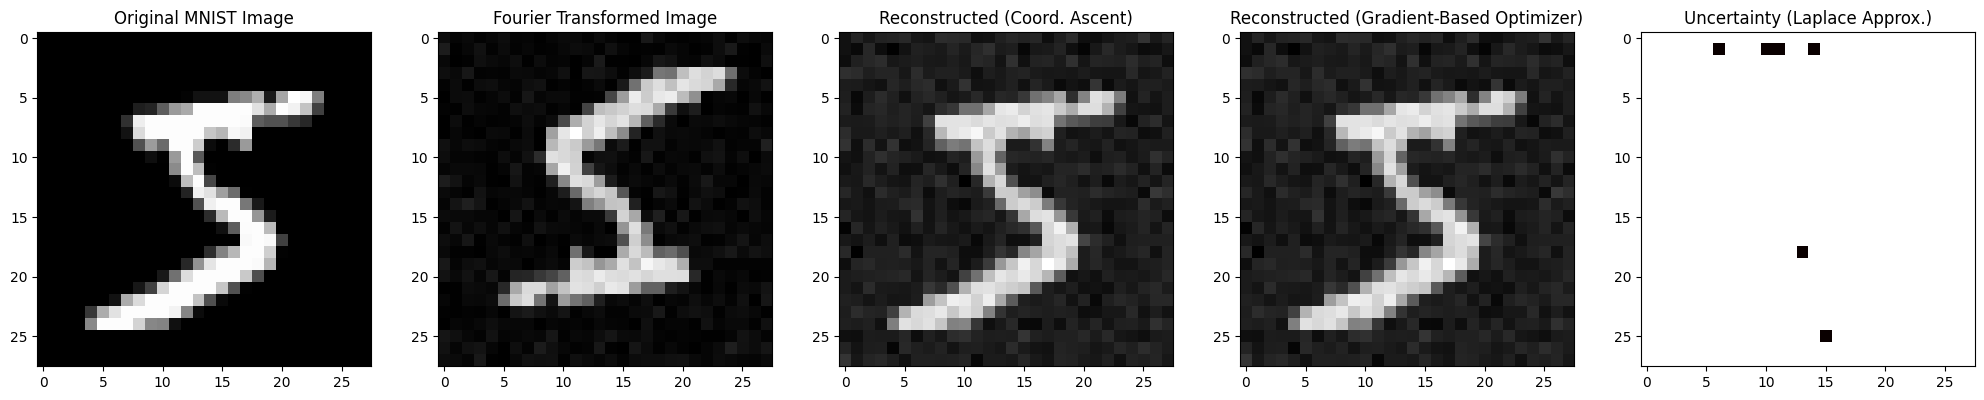

Coordinate Ascent Tau²: 0.005066
Gradient-Based Optimized Tau²: 23.568197


In [16]:
# Compute MAP estimates using Bayesian hierarchical model with Fourier transform
X_map_fourier, tau2_estimate = coordinate_ascent_fourier(A, Y)
X_map_gradient, tau2_gradient = gradient_based_optimizer(A, Y)

# Compute Laplace Approximation
X_map, covariance = laplace_approximation(A, X_map_fourier)

# Reshape for visualization
X_map_fourier_img = X_map_fourier.reshape(28, 28)
X_map_gradient_img = X_map_gradient.reshape(28, 28)

# --- Visualization ---
plt.figure(figsize=(25, 5))

plt.subplot(1, 5, 1)
plt.imshow(img_array, cmap="gray")
plt.title("Original MNIST Image")

plt.subplot(1, 5, 2)
plt.imshow(np.abs(Y.reshape(28, 28)), cmap="gray")
plt.title("Fourier Transformed Image")

plt.subplot(1, 5, 3)
plt.imshow(X_map_fourier_img, cmap="gray")
plt.title("Reconstructed (Coord. Ascent)")

plt.subplot(1, 5, 4)
plt.imshow(X_map_gradient_img, cmap="gray")
plt.title("Reconstructed (Gradient-Based Optimizer)")

# Visualizing uncertainty (Laplace Approximation)
uncertainty = np.sqrt(np.diag(covariance)).reshape(28, 28)
plt.subplot(1, 5, 5)
plt.imshow(uncertainty, cmap="hot")
plt.title("Uncertainty (Laplace Approx.)")

plt.show()

# Print estimated τ² (hierarchical prior)
print(f"Coordinate Ascent Tau²: {tau2_estimate:.6f}")
print(f"Gradient-Based Optimized Tau²: {tau2_gradient:.6f}")